## Low-level concepts comparison

In [1]:
import os
#virtually move to parent directory
os.chdir("../")

import torch
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import utils
import data_utils
import similarity

from collections import Counter

# Set font size for plots
font_size = 14
font = {'size': font_size}
matplotlib.rc('font', **font)

## Plotting

In [2]:
# Your normalization parameters
mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
std = torch.tensor([0.26862954, 0.26130258, 0.27577711])

# Function to unnormalize an image
def unnormalize(image):
    # Convert the tensor image to float and move the color channel to the last dimension
    image = image.float().permute(1, 2, 0)
    # Unnormalize the image
    image = (image * std) + mean
    # Clip the values to be between 0 and 1
    image = torch.clamp(image, 0, 1)
    return image

In [3]:
def get_top_K_neurons(similarity_matrix, target_activations, similarities, pil_data, K=10, L=5, display=False):
    # Constants
    K = 10  # Top K neurons
    L = 5   # Top L words

    # Compute mean activations across images and find top K neurons
    mean_activations = torch.mean(torch.abs(target_activations), dim=0) # 1, num_activations
    top_vals, top_neurons = torch.topk(mean_activations, k=K, largest=True) # 1, K

    # # Print the top K neurons and their mean activations
    # for i, neuron in enumerate(top_neurons):
    #     print(f"Neuron {int(neuron)}: {top_vals[i]}")

    # print('\n\n')
    # Find top L words for each top K neuron and store in a dictionary
    top_words_dict = {}
    all_top_words = []  # List to accumulate all top words

    for neuron in top_neurons:
        scores, top_words = torch.topk(similarities[neuron], k=L, largest=True)
        top_words_dict[int(neuron)] = [(words[w], scores[e].item() )for e, w in enumerate(top_words)]

        print(f"Neuron {neuron}: {top_words_dict[int(neuron)]}")
        all_top_words.extend(top_words)

    # print('\n')
    # print(f"Top {L} words for each top {K} neuron:")
    # for neuron, top_words in top_words_dict.items():
    #     print(f"Neuron {neuron}: {top_words}")
        
    if display:
        for neuron in top_neurons:
            fig, axs = plt.subplots(nrows=1, ncols=K, figsize=[15, 3])
            fig.suptitle(f"Neuron {int(neuron)}")

            scores, clip_top_word = torch.topk(similarity_matrix[:, neuron], k=K, largest=True)
            top_images = torch.topk(target_activations[:, neuron], k=K, largest=True).indices
            for i, img_id in enumerate(top_images):
                im, label = pil_data[img_id]
                im = im.resize([375, 375])
                axs[i].imshow(im)
                axs[i].axis('off')
                axs[i].set_title(f"CLIP: {words[clip_top_word]}")
            
            plt.tight_layout()

            plt.show()
            
    # Compute unique words and their occurrence frequency
    word_frequency = Counter(all_top_words)

    return word_frequency, top_neurons

In [29]:

def plot_top_k_concepts_neurons(target_activations, similarities_clip, similarities_plumber, pil_data, class_names, K, L, target_layer=None, display=False):
    

    # # Compute mean activations across images and find top K neurons
    mean_activations = torch.mean(target_activations, dim=0) # 1, num_activations
    # top_vals, top_neurons = torch.topk(mean_activations, k=K, largest=True) # 1, K

    # Get the top k from bottom
    top_vals, top_neurons = torch.topk(-1*mean_activations, k=K, largest=True) # 1, K



    # Find top L words for each top K neuron and store in a dictionary
    top_words_dict_clip = {}
    top_words_dict_plumber = {}

    for neuron in top_neurons:
        scores_clip, top_words_clip = torch.topk(similarities_clip[neuron], k=L, largest=True)
        scores_plumber, top_words_plumber = torch.topk(similarities_plumber[neuron], k=L, largest=True)

        top_words_dict_clip[int(neuron)] = [(words[w], scores_clip[e].item() )for e, w in enumerate(top_words_clip)]
        top_words_dict_plumber[int(neuron)] = [(words[w], scores_plumber[e].item() )for e, w in enumerate(top_words_plumber)]

        print(f"\nNeuron {neuron}: \nCLIP:{top_words_dict_clip[int(neuron)]}\nPLUMBER:{top_words_dict_plumber[int(neuron)]}")


    _, top_image_ids = torch.topk(target_activations, k=K, dim=0) # top K images for each neuron , top_ids = [K, 512]
    
    all_top_words = []  # List to accumulate all top words

    for j, neuron in enumerate(top_neurons):
        # Get the top L words for the neuron
        scores_clip, top_words_clip = torch.topk(similarities_clip[neuron], k=L, largest=True)
        scores_plumber, top_words_plumber = torch.topk(similarities_plumber[neuron], k=L, largest=True)

        top_words_clip = [words[int(id)] for id in top_words_clip]
        top_words_plumber = [words[int(id)] for id in top_words_plumber]
        
        if display:
            
            # Plotting (Optional based on your requirement)
            fig, axs = plt.subplots(nrows=1, ncols=K, figsize=[15, 3])
            fig.suptitle(f"Layer {target_layer} Neuron {int(neuron)}: \n\nCLIP-dissect top {L} words: {top_words_clip}\nPlumber top {L} words: {top_words_plumber}\n")
            # Iterate over top K images for the neuron
            for i, top_id in enumerate(top_image_ids[:, neuron]):
                im, label = pil_data[top_id]
                im = im.resize([375, 375])
                axs[i].imshow(im)
                axs[i].axis('off')
                axs[i].set_title(f"{class_names[label]}")

        plt.tight_layout()
        plt.show()

    # Compute unique words and their occurrence frequency
    word_frequency = Counter(all_top_words)

    return word_frequency

In [30]:
clip_name = 'ViT-B/32'
d_probe = 'custom_domainnet'
batch_size = 200
device = 'cuda'
pool_mode = 'max'
domain = 'real'
similarity_fn = similarity.soft_wpmi

target_name = 'plumber'
target_layers = ['ln_post'] # ln_post, transformer.11, transformer.10
concept_set = 'clip-dissect/concepts/20k.txt'

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

def do_CLIP_dissect(d_probe, target_layer, target_name, device, domain):

    save_dir = 'saved_activations/'
    save_dir = os.path.join(save_dir, domain)
    utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = target_layer, 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir, domain=domain)

    # No Transformations are applied to the images
    pil_data = data_utils.get_data(d_probe, domain=domain) 
    
    save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer[0], d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

    target_save_name, clip_save_name, text_save_name, plumber_save_name = save_names

    clip_similarities, plumber_similarities, target_activations, similarity_matrix = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                text_save_name, plumber_save_name, similarity_fn, device=device)

    return clip_similarities, plumber_similarities, target_activations, pil_data, similarity_matrix

## Domain Real

Number of classes in real probe set: 345
Number of images in real probe set: 5044

Number of classes in real probe set: 345
Number of images in real probe set: 5044

Number of classes in real probe set: 345
Number of images in real probe set: 5044

CLIP Image-Text similarity matrix shape: torch.Size([5044, 20000])
Plumber Image-Text similarity matrix shape: torch.Size([5044, 20000])
Target feature matrix shape: torch.Size([5044, 768])


100%|██████████| 768/768 [00:03<00:00, 245.92it/s]


Target Activation-Concept Similarity matrix (CLIP) shape: torch.Size([768, 20000])


100%|██████████| 768/768 [00:03<00:00, 229.59it/s]


Target Activation-Concept Similarity matrix (CLIP) shape: torch.Size([768, 20000])

Neuron 604: 
CLIP:[('uss', 6.642578125), ('robin', 4.843536376953125), ('franz', 4.77740478515625), ('python', 4.545379638671875), ('hp', 4.45758056640625)]
PLUMBER:[('bombing', 5.08782958984375), ('fog', 4.711212158203125), ('aircraft', 4.145751953125), ('geophysical', 3.719970703125), ('somebody', 3.155181884765625)]

Neuron 625: 
CLIP:[('canoeing', 6.643341064453125), ('kayak', 6.64306640625), ('stormwater', 6.39007568359375), ('rafting', 5.937957763671875), ('turbine', 5.642486572265625)]
PLUMBER:[('canoe', 6.643798828125), ('canoeing', 6.643707275390625), ('migrating', 3.73028564453125), ('billiards', 2.774871826171875), ('renewable', 1.8642578125)]

Neuron 167: 
CLIP:[('cylinder', 5.8795166015625), ('dispenser', 5.5401611328125), ('fork', 5.151885986328125), ('electrode', 4.874908447265625), ('figurine', 4.747955322265625)]
PLUMBER:[('mixture', 5.5008544921875), ('ratio', 5.426300048828125), ('the

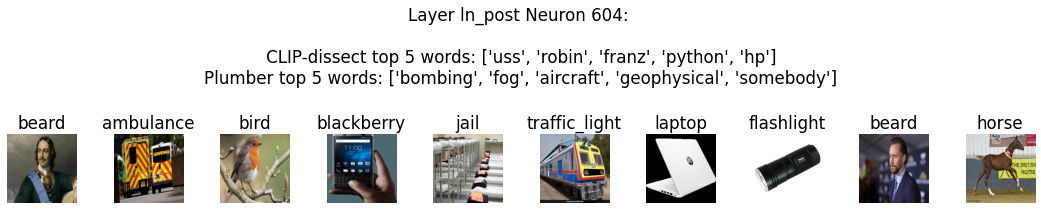

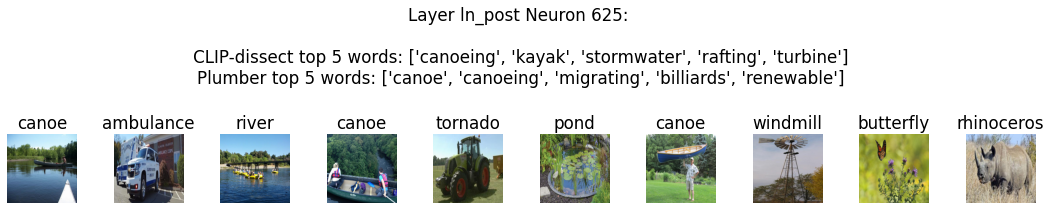

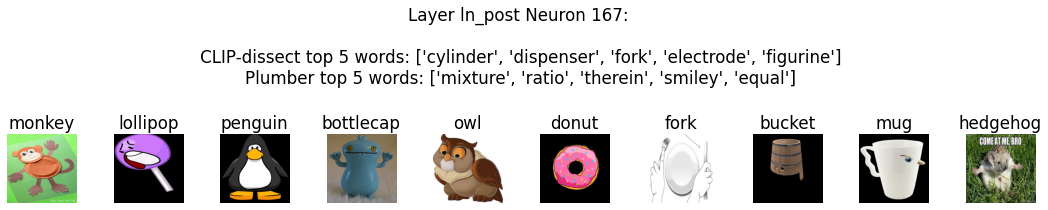

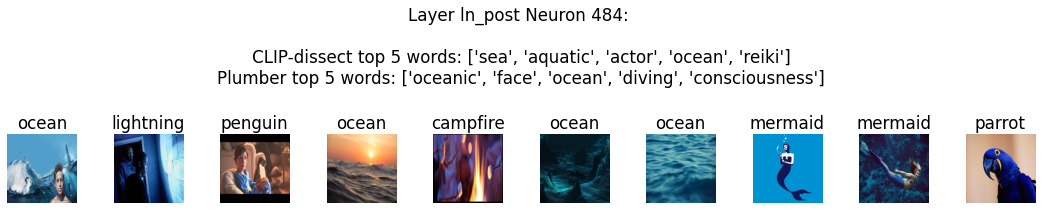

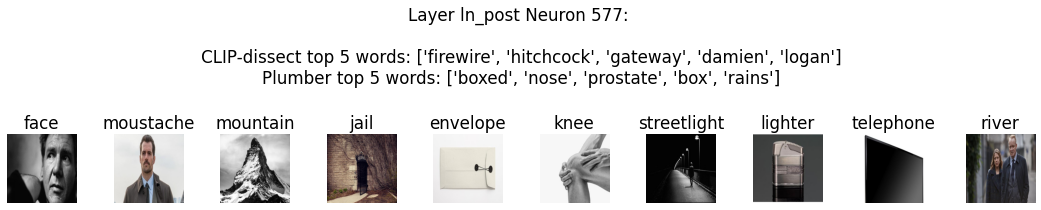

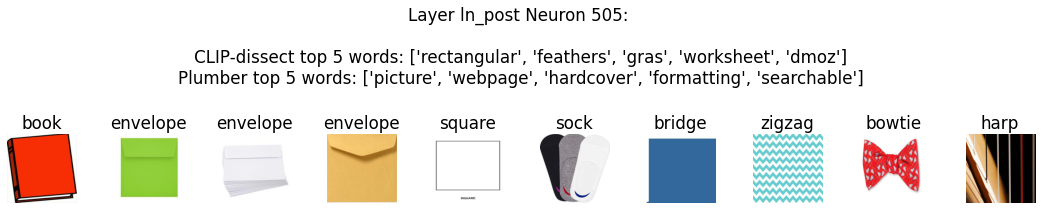

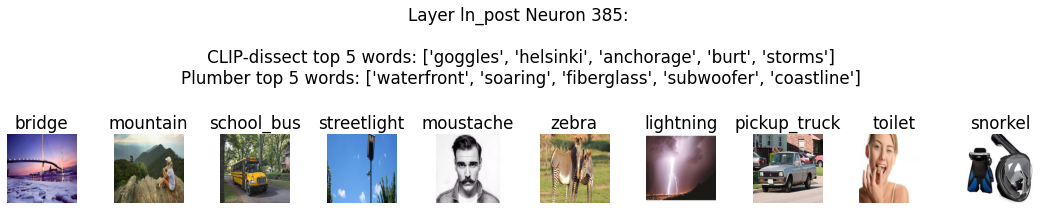

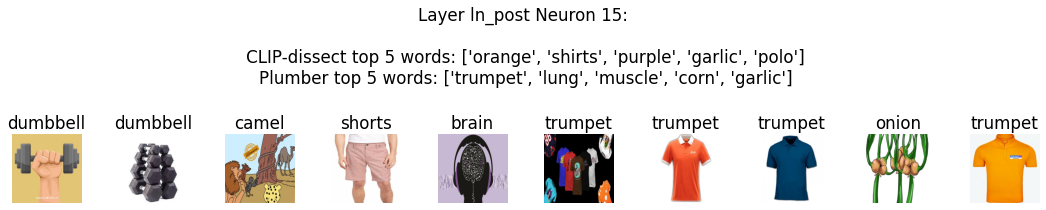

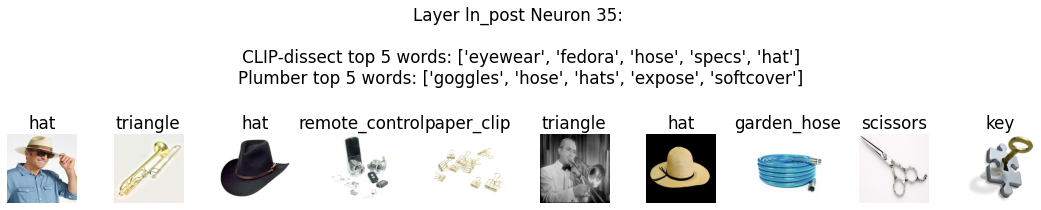

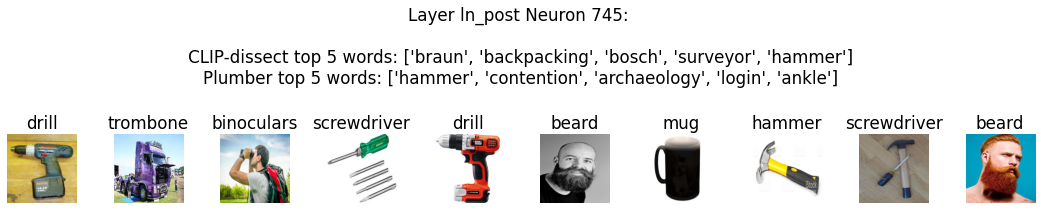


#############################################



In [31]:
for target_layer in target_layers:
    
    clip_similarities, plumber_similarities, target_activations, pil_data, clip_similarity_matrix = do_CLIP_dissect(d_probe, [target_layer], target_name, device, domain='real')
    # top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_similarity_matrix, target_activations, clip_similarities, pil_data, K=10, L=5)
    
   
    complete_word_frequency = plot_top_k_concepts_neurons(target_activations, clip_similarities, plumber_similarities, K=10, L=5, 
                                                          pil_data=pil_data, class_names=pil_data.class_names,
                                                          target_layer= target_layer, display=True)

    print('\n#############################################\n')
    # top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_similarity_matrix, target_activations, plumber_similarities, pil_data, K=10, L=5)
        
    # complete_word_frequency = plot_top_k_concepts_neurons(_, target_activations, similarities=plumber_similarities, K=10, L=5, pil_data=pil_data, 
    #                                                     neurons_to_check=top_neurons, target_layer= target_layer, display=True)

## Domain- Sketch

Number of classes in sketch probe set: 345
Number of images in sketch probe set: 1946

Number of classes in sketch probe set: 345
Number of images in sketch probe set: 1946

Number of classes in sketch probe set: 345
Number of images in sketch probe set: 1946

CLIP Image-Text similarity matrix shape: torch.Size([1946, 20000])
Plumber Image-Text similarity matrix shape: torch.Size([1946, 20000])
Target feature matrix shape: torch.Size([1946, 768])


100%|██████████| 768/768 [00:03<00:00, 245.57it/s]


Target Activation-Concept Similarity matrix (CLIP) shape: torch.Size([768, 20000])


100%|██████████| 768/768 [00:03<00:00, 242.75it/s]


Target Activation-Concept Similarity matrix (CLIP) shape: torch.Size([768, 20000])

Neuron 167: 
CLIP:[('garrison', 5.252685546875), ('rat', 4.833160400390625), ('ventricular', 4.737884521484375), ('edmund', 4.397705078125), ('bart', 4.32159423828125)]
PLUMBER:[('bacterial', 5.1419677734375), ('penguin', 3.64459228515625), ('hog', 3.08343505859375), ('cylinder', 3.06085205078125), ('breast', 2.087799072265625)]

Neuron 16: 
CLIP:[('goblet', 5.4674072265625), ('spinal', 4.19873046875), ('columns', 3.9444580078125), ('bell', 3.8680419921875), ('wagon', 3.661468505859375)]
PLUMBER:[('hyperlink', 1.329010009765625), ('upskirts', 0.717071533203125), ('rail', 0.39129638671875), ('cameltoe', 0.36419677734375), ('appraisals', 0.3358154296875)]

Neuron 577: 
CLIP:[('rotor', 4.1630859375), ('posterior', 4.144073486328125), ('shadow', 3.713897705078125), ('unisex', 3.44268798828125), ('volkswagen', 3.408935546875)]
PLUMBER:[('correctional', 1.68914794921875), ('container', 1.475616455078125), ('s

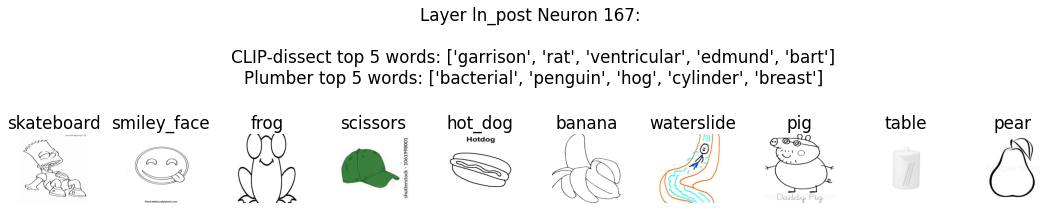

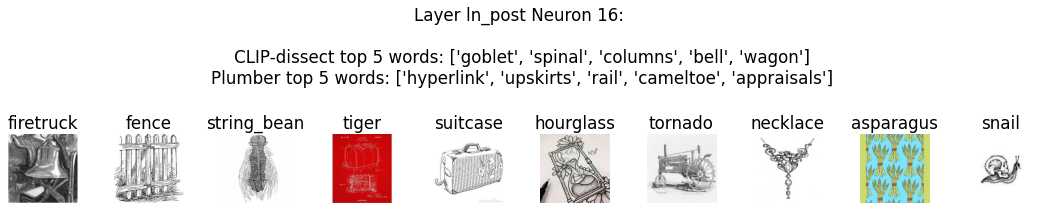

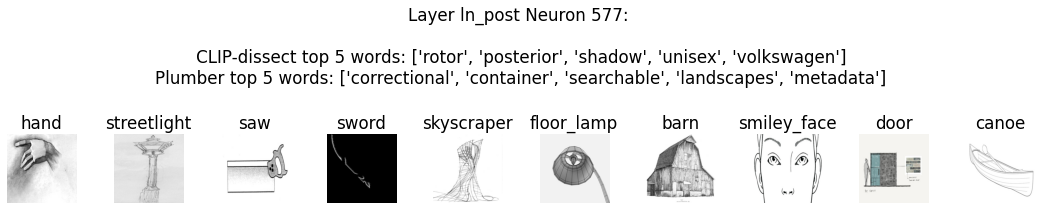

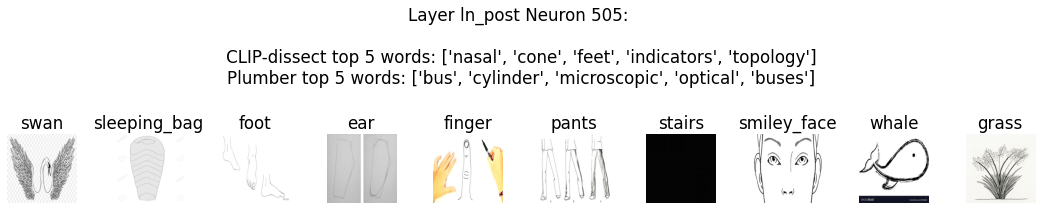

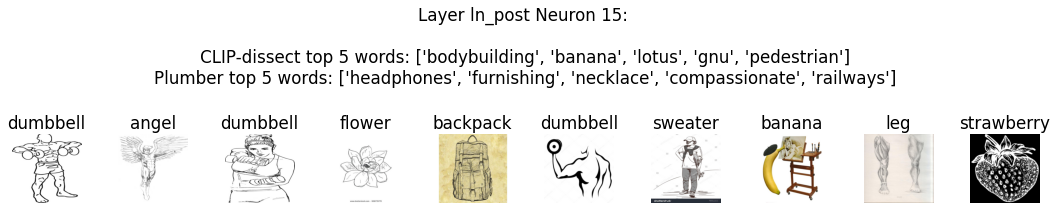

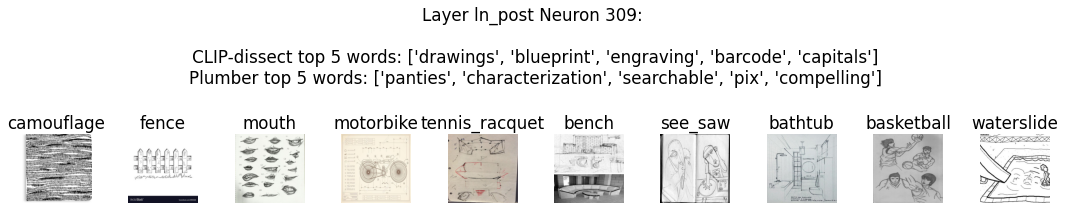

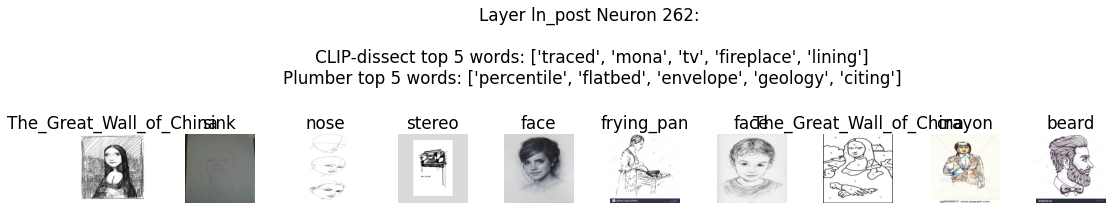

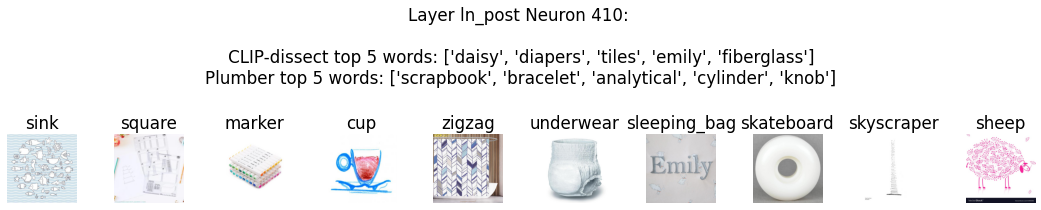

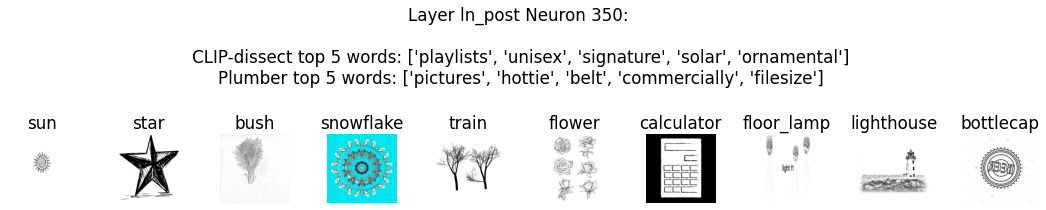

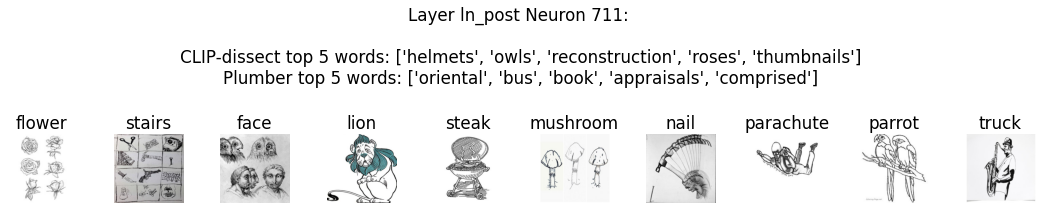

In [32]:
for target_layer in target_layers:
    
    clip_similarities, plumber_similarities, target_activations, pil_data, clip_similarity_matrix = do_CLIP_dissect(d_probe, [target_layer], 
                                                                                                                    target_name, device, domain='sketch')
    # top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_similarity_matrix, target_activations, clip_similarities, pil_data, K=10, L=5)
    
   
    complete_word_frequency = plot_top_k_concepts_neurons(target_activations, clip_similarities, plumber_similarities, K=10, L=5, 
                                                          pil_data=pil_data, class_names=pil_data.class_names,
                                                          target_layer= target_layer, display=True)

## Painting

Number of classes in painting probe set: 344
Number of images in painting probe set: 2062

Number of classes in painting probe set: 344
Number of images in painting probe set: 2062

Number of classes in painting probe set: 344
Number of images in painting probe set: 2062

CLIP Image-Text similarity matrix shape: torch.Size([2062, 20000])
Plumber Image-Text similarity matrix shape: torch.Size([2062, 20000])
Target feature matrix shape: torch.Size([2062, 768])


100%|██████████| 768/768 [00:03<00:00, 252.84it/s]


Target Activation-Concept Similarity matrix (CLIP) shape: torch.Size([768, 20000])


100%|██████████| 768/768 [00:03<00:00, 237.01it/s]


Target Activation-Concept Similarity matrix (CLIP) shape: torch.Size([768, 20000])


Neuron 336: 
CLIP:[('shorts', 3.9119873046875), ('family', 3.86572265625), ('patriotic', 3.84600830078125), ('paige', 3.719482421875), ('rosa', 3.570556640625)]
PLUMBER:[('face', 6.5782470703125), ('sweater', 6.024993896484375), ('hardback', 4.177581787109375), ('sweaters', 3.85614013671875), ('hardcover', 3.802154541015625)]


Neuron 624: 
CLIP:[('painter', 6.450164794921875), ('social', 6.270660400390625), ('painters', 4.812286376953125), ('tibetan', 4.56158447265625), ('roofing', 4.1710205078125)]
PLUMBER:[('roofing', 6.40386962890625), ('handbag', 5.858428955078125), ('hospital', 5.6812744140625), ('leg', 5.595306396484375), ('bus', 5.536712646484375)]


Neuron 255: 
CLIP:[('curb', 5.251495361328125), ('laminated', 4.33294677734375), ('lettering', 4.20391845703125), ('mariners', 3.884246826171875), ('freight', 3.7689208984375)]
PLUMBER:[('buses', 4.95977783203125), ('bridging', 3.85308837890625), (

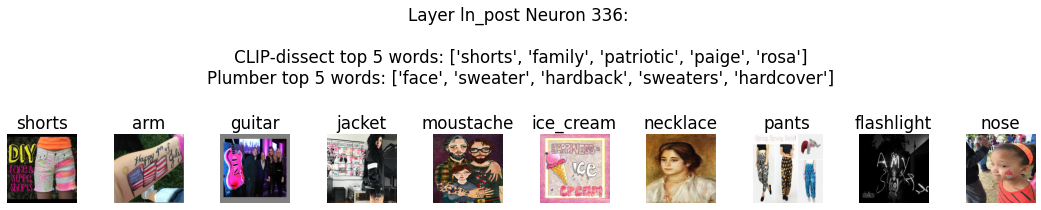

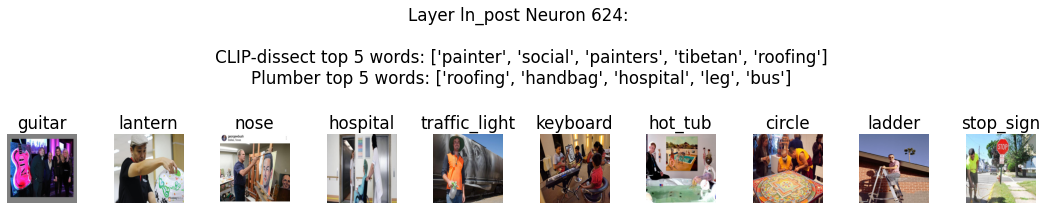

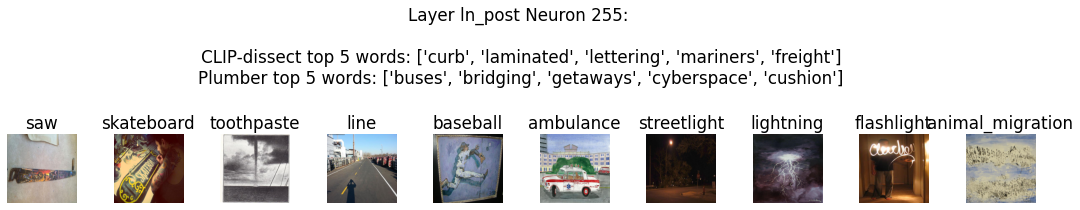

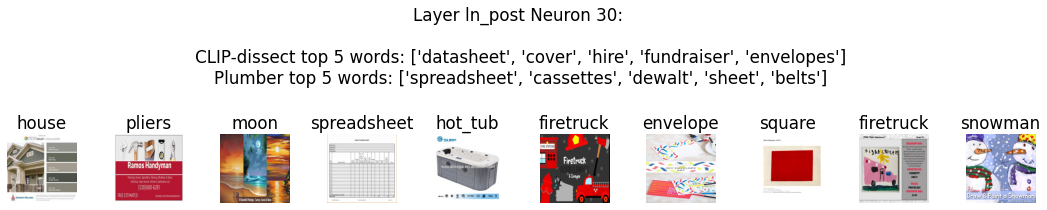

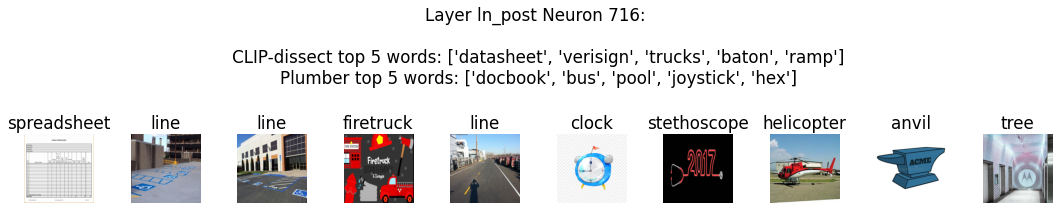

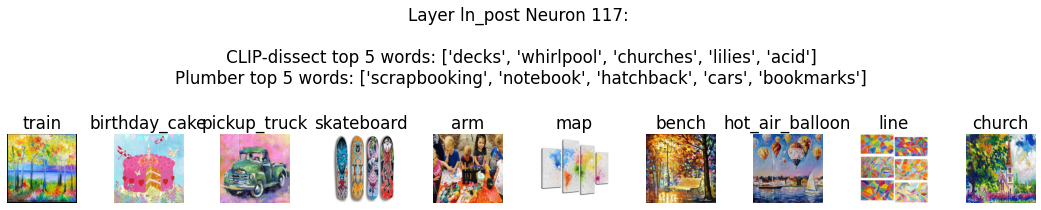

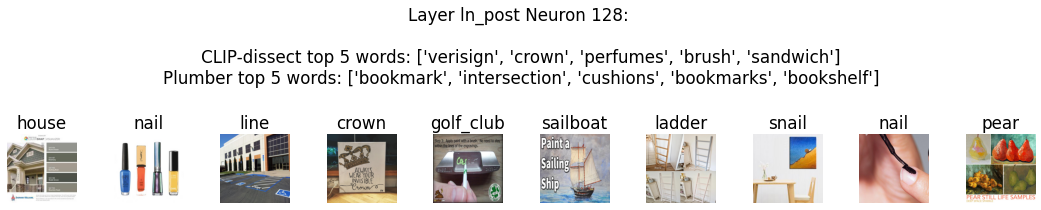

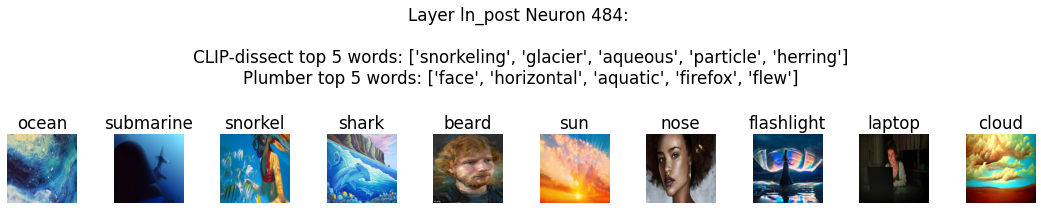

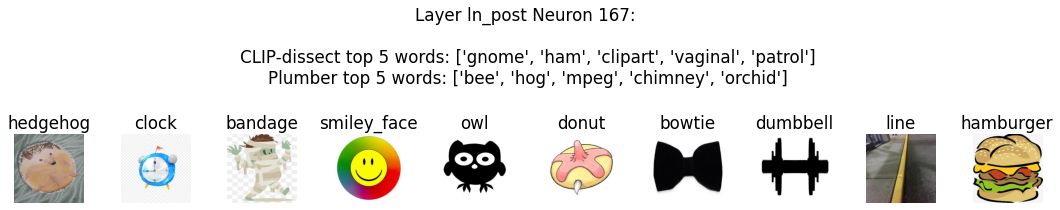

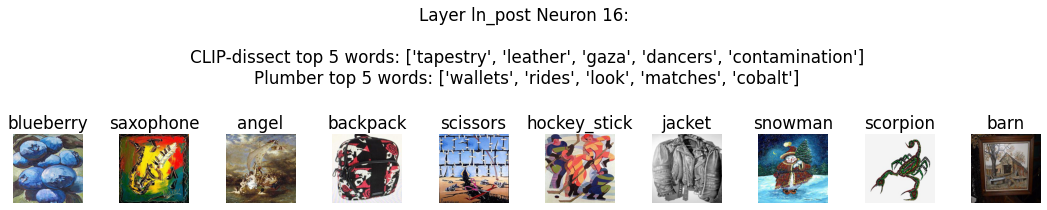

In [17]:
for target_layer in target_layers:
    
    clip_similarities, plumber_similarities, target_activations, pil_data, clip_similarity_matrix = do_CLIP_dissect(d_probe, [target_layer], 
                                                                                                                    target_name, device, domain='painting')
    # top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_similarity_matrix, target_activations, clip_similarities, pil_data, K=10, L=5)
    
   
    complete_word_frequency = plot_top_k_concepts_neurons(target_activations, clip_similarities, plumber_similarities, K=10, L=5, 
                                                          pil_data=pil_data, class_names=pil_data.class_names,
                                                          target_layer= target_layer, display=True)

## Domain Sketch Painting Clipart

In [ ]:
for target_layer in target_layers:
    
    clip_similarities, plumber_similarities, target_activations, pil_data, clip_similarity_matrix = do_CLIP_dissect(d_probe, [target_layer], target_name, device, domain='spc')
    top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_similarity_matrix, target_activations, clip_similarities, pil_data, K=10, L=5)
    
   
    complete_word_frequency = plot_top_k_concepts_neurons(_, target_activations, similarities=clip_similarities, K=10, L=5, pil_data=pil_data, 
                                                        neurons_to_check=top_neurons, target_layer= target_layer, display=True)

    print('\n#############################################\n')
    top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_similarity_matrix, target_activations, plumber_similarities, pil_data, K=10, L=5)
        
    complete_word_frequency = plot_top_k_concepts_neurons(_, target_activations, similarities=plumber_similarities, K=10, L=5, pil_data=pil_data, 
                                                        neurons_to_check=top_neurons, target_layer= target_layer, display=True)

In [ ]:
import clip

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

print(clip_model.visual.transformer.resblocks)